In [1]:
import os
os.chdir("..")

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import pandas as pd
import seaborn as sns
import torch

from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from typing import Dict

from engine.attention import AttentionAudioClassifier
from engine.data import (
    get_data_loader,
    get_label_mapping,
    get_main_classes_loader,
    get_commands_loader,
    decode_composed_model_predictions
)
plt.xticks(rotation=90)
plt.clf()

<Figure size 640x480 with 0 Axes>

In [3]:
def get_labels_and_predictions(model, loader):
    all_labels, all_predictions = [], []
    for X, y in loader:
        prediction = model(X).argmax(dim=1)
        all_labels.append(y.cpu().numpy())
        all_predictions.append(prediction.cpu().numpy())
    labels = np.concatenate(all_labels)
    predictions = np.concatenate(all_predictions)
    return labels, predictions

In [4]:
def get_composed_model_labels_and_predictions(main_model, command_model, loader):
    all_labels, all_predictions = [], []
    for X, y in loader:
        prediction = main_model(X).argmax(dim=1)
        prediction[prediction == 1] = -1
        prediction[prediction == 2] = -2
        if (prediction == 0).sum() > 0:
            prediction[prediction == 0] = commands_model(X[prediction == 0]).argmax(dim=1)
        all_labels.append(y.cpu().numpy())
        all_predictions.append(prediction.cpu().numpy())
    labels = np.concatenate(all_labels)
    predictions = np.concatenate(all_predictions)
    return labels, predictions

## All labels

In [5]:
## Load
models_paths = list(Path("results/attention_all_classes").rglob("*.ckpt"))
loader = get_data_loader("test")

In [6]:
## Get accuracies
accuracies_all_labels = []
for path in models_paths:
    model = AttentionAudioClassifier.load_from_checkpoint(path)
    labels, predictions = get_labels_and_predictions(model, loader)
    accuracies_all_labels.append((labels == predictions).mean())

Text(0.5, 1.0, 'Confusion matrix of attention model on all labels')

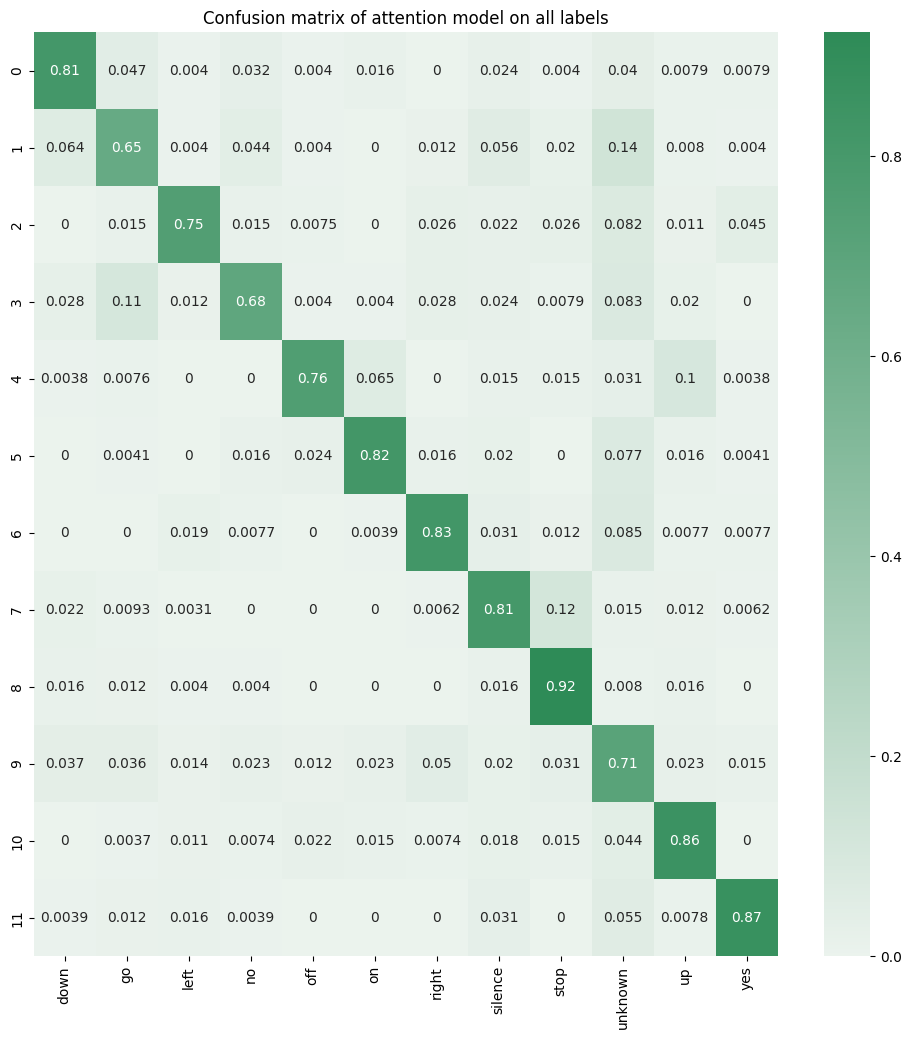

In [7]:
# Confusion matrix
best_model_path = models_paths[np.argmax(accuracies_all_labels)]
best_model = AttentionAudioClassifier.load_from_checkpoint(best_model_path)
labels, predictions = get_labels_and_predictions(model, loader)

mapping = get_label_mapping("all")
matrix = confusion_matrix(labels, predictions)
matrix = (matrix.T / matrix.sum(axis=1)).T
display_labels=[mapping[label] for label in sorted(np.unique(labels))]

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(matrix, ax=ax, annot=True, cmap=sns.light_palette("seagreen", as_cmap=True))
ax.set_xticklabels(display_labels, rotation=90)
ax.set_title("Confusion matrix of attention model on all labels")

## Main classes

In [8]:
## Load
models_paths = list(Path("results/attention_main_classes").rglob("*.ckpt"))
loader = get_main_classes_loader("test")

In [9]:
## Get accuracies
accuracies_main_labels = []
for path in models_paths:
    model = AttentionAudioClassifier.load_from_checkpoint(path)
    labels, predictions = get_labels_and_predictions(model, loader)
    accuracies_main_labels.append((labels == predictions).mean())

Text(0.5, 1.0, 'Confusion matrix of attention model on main labels')

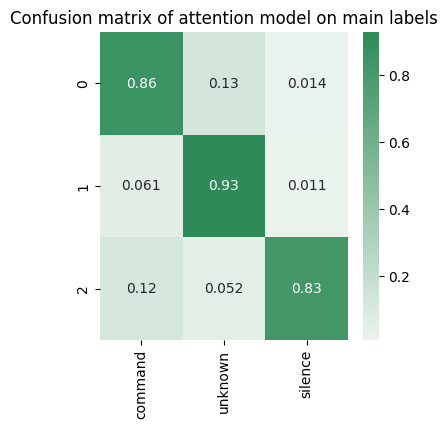

In [10]:
# Confusion matrix
best_model_path = models_paths[np.argmax(accuracies_main_labels)]
best_model = AttentionAudioClassifier.load_from_checkpoint(best_model_path)
labels, predictions = get_labels_and_predictions(model, loader)

mapping = get_label_mapping("main")
matrix = confusion_matrix(labels, predictions)
matrix = (matrix.T / matrix.sum(axis=1)).T
display_labels=[mapping[label] for label in sorted(np.unique(labels))]

fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(matrix, ax=ax, annot=True, cmap=sns.light_palette("seagreen", as_cmap=True))
ax.set_xticklabels(display_labels, rotation=90)
ax.set_title("Confusion matrix of attention model on main labels")

## Commands only

In [11]:
## Load
models_paths = list(Path("results/attention_commands_only").rglob("*.ckpt"))
loader = get_commands_loader("test")

In [12]:
## Get accuracies
accuracies_commands_labels = []
for path in models_paths:
    model = AttentionAudioClassifier.load_from_checkpoint(path)
    labels, predictions = get_labels_and_predictions(model, loader)
    accuracies_commands_labels.append((labels == predictions).mean())

Text(0.5, 1.0, 'Confusion matrix of attention model on only commands')

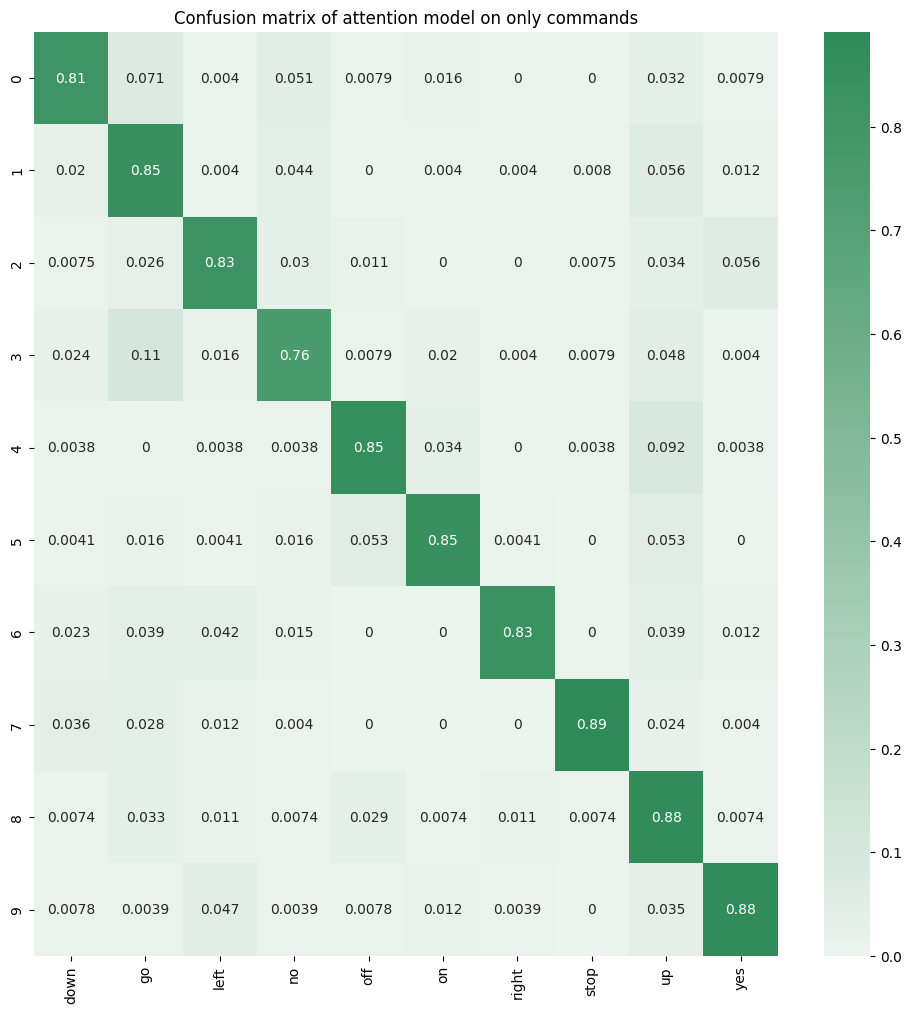

In [13]:
# Confusion matrix
best_model_path = models_paths[np.argmax(accuracies_commands_labels)]
best_model = AttentionAudioClassifier.load_from_checkpoint(best_model_path)
labels, predictions = get_labels_and_predictions(model, loader)

mapping = get_label_mapping("commands_only")
matrix = confusion_matrix(labels, predictions)
matrix = (matrix.T / matrix.sum(axis=1)).T
display_labels=[mapping[label] for label in sorted(np.unique(labels))]

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(matrix, ax=ax, annot=True, cmap=sns.light_palette("seagreen", as_cmap=True))
ax.set_xticklabels(display_labels, rotation=90)
ax.set_title("Confusion matrix of attention model on only commands")

## Composed model

In [14]:
## Load
main_models_paths = list(Path("results/attention_main_classes").rglob("*.ckpt"))
commands_models_paths = list(Path("results/attention_commands_only").rglob("*.ckpt"))
loader = get_data_loader("test")

In [15]:
accuracies_composed_model = []

for main_model_path, commands_model_path in zip(main_models_paths, commands_models_paths):
    main_model = AttentionAudioClassifier.load_from_checkpoint(main_model_path)
    commands_model = AttentionAudioClassifier.load_from_checkpoint(commands_model_path)
    labels, predictions = get_composed_model_labels_and_predictions(main_model, commands_model, loader)
    accuracies_composed_model.append(
        (labels == decode_composed_model_predictions(predictions)).mean()
    )

Text(0.5, 1.0, 'Confusion matrix of composed attention model')

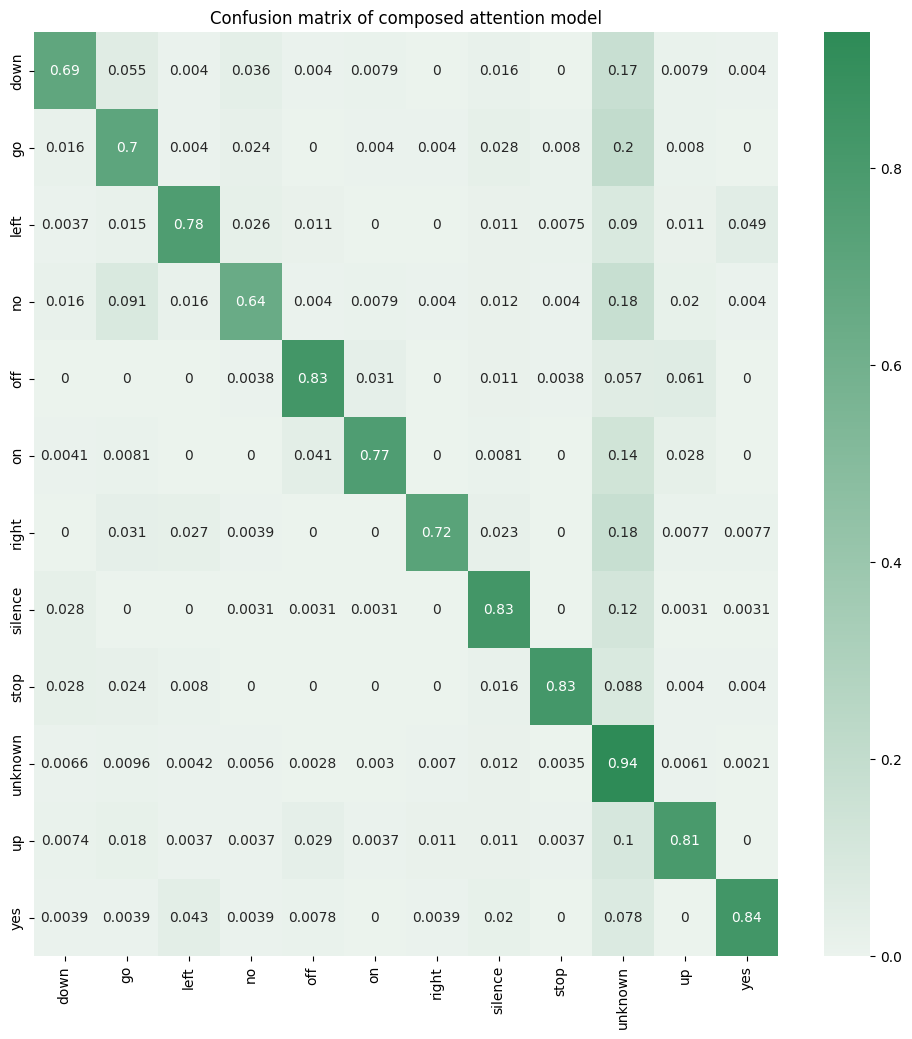

In [17]:
# Confusion matrix
best_model_idx = np.argmax(accuracies_composed_model)
best_main_model = AttentionAudioClassifier.load_from_checkpoint(main_models_paths[best_model_idx])
best_commands_model = AttentionAudioClassifier.load_from_checkpoint(commands_models_paths[best_model_idx])

labels, predictions = get_composed_model_labels_and_predictions(best_main_model, best_commands_model, loader)
predictions = decode_composed_model_predictions(predictions)

matrix = confusion_matrix(labels, predictions)
matrix = (matrix.T / matrix.sum(axis=1)).T

mapping = get_label_mapping("all")
display_labels=[mapping[label] for label in sorted(np.unique(labels))]

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(matrix, ax=ax, annot=True, cmap=sns.light_palette("seagreen", as_cmap=True))
ax.set_xticklabels(display_labels, rotation=90)
ax.set_yticklabels(display_labels)
ax.set_title("Confusion matrix of composed attention model")

## Summary of the performance

Text(0.5, 1.0, 'Comparison of final models')

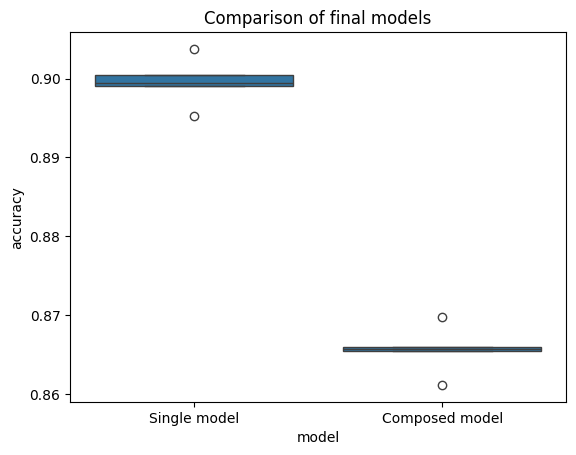

In [41]:
performance_df = pd.DataFrame(
    {
        "accuracy": accuracies_main_labels + accuracies_composed_model,
        "model": ["Single model"] * len(accuracies_main_labels) + ["Composed model"] * len(accuracies_composed_model)
    }
)
performance_df.to_csv("final_results.csv", index=False)
plot = sns.boxplot(data=performance_df, x="model", y="accuracy")
plot.set_title("Comparison of final models")